In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import time


In [3]:
class AdaPConv(nn.Module):
    def __init__(self, dim, kernel_size=3):
        super().__init__()
        self.dim = dim

        # Router: Decides contribution of each branch
        # Outputs 3 weights: [Simple (1/8), Standard (1/4), Complex (1/2)]
        self.router = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(dim, 3),
            nn.Softmax(dim=1)
        )

        # Branch Definitions
        # We use 'groups' in Conv2d to simulate PConv for efficiency in this demo
        # Simple: 1/8 channels processed
        self.c_simple = dim // 8
        self.conv_simple = nn.Conv2d(self.c_simple, self.c_simple, kernel_size, padding=1, bias=False)

        # Standard: 1/4 channels processed
        self.c_std = dim // 4
        self.conv_std = nn.Conv2d(self.c_std, self.c_std, kernel_size, padding=1, bias=False)

        # Complex: 1/2 channels processed
        self.c_complex = dim // 2
        self.conv_complex = nn.Conv2d(self.c_complex, self.c_complex, kernel_size, padding=1, bias=False)

    def forward(self, x):
        # 1. Calculate Routing Weights
        # Shape: (Batch, 3) -> (Batch, 3, 1, 1) for broadcasting
        w = self.router(x).unsqueeze(-1).unsqueeze(-1)

        # 2. Process Branches
        # Branch 1: Simple (Process 1/8, Pass 7/8)
        x_s_active, x_s_passive = torch.split(x, [self.c_simple, self.dim - self.c_simple], dim=1)
        out_simple = torch.cat([self.conv_simple(x_s_active), x_s_passive], dim=1)

        # Branch 2: Standard (Process 1/4, Pass 3/4)
        x_std_active, x_std_passive = torch.split(x, [self.c_std, self.dim - self.c_std], dim=1)
        out_std = torch.cat([self.conv_std(x_std_active), x_std_passive], dim=1)

        # Branch 3: Complex (Process 1/2, Pass 1/2)
        x_c_active, x_c_passive = torch.split(x, [self.c_complex, self.dim - self.c_complex], dim=1)
        out_complex = torch.cat([self.conv_complex(x_c_active), x_c_passive], dim=1)

        # 3. Soft Fusion (Weighted Sum)
        # Allows gradient flow to the router during training
        return (out_simple * w[:, 0:1]) + (out_std * w[:, 1:2]) + (out_complex * w[:, 2:3])

In [4]:
class MLPBlock(nn.Module):
    """ The 1x1 Conv part of FasterNet (Inverted Residual) """
    def __init__(self, dim, mlp_ratio=2):
        super().__init__()
        hidden_dim = int(dim * mlp_ratio)
        self.net = nn.Sequential(
            nn.Conv2d(dim, hidden_dim, 1, bias=False),
            nn.BatchNorm2d(hidden_dim),
            nn.GELU(),
            nn.Conv2d(hidden_dim, dim, 1, bias=False),
            nn.BatchNorm2d(dim)
        )
    def forward(self, x):
        return self.net(x)

class FasterNetBlock(nn.Module):
    """ Standard FasterNet Block with Fixed PConv (1/4) """
    def __init__(self, dim):
        super().__init__()
        self.pconv_dim = dim // 4
        self.conv = nn.Conv2d(self.pconv_dim, self.pconv_dim, 3, padding=1, bias=False)
        self.mlp = MLPBlock(dim)

    def forward(self, x):
        # Fixed slicing for PConv
        x_p, x_rest = torch.split(x, [self.pconv_dim, x.shape[1] - self.pconv_dim], dim=1)
        x_p = self.conv(x_p)
        x_pconv = torch.cat([x_p, x_rest], dim=1)

        # PWConv + Residual
        return x + self.mlp(x_pconv)

class AdaFasterNetBlock(nn.Module):
    """ Our Custom Block with Ada-PConv """
    def __init__(self, dim):
        super().__init__()
        self.ada_pconv = AdaPConv(dim)
        self.mlp = MLPBlock(dim)

    def forward(self, x):
        x_pconv = self.ada_pconv(x)
        return x + self.mlp(x_pconv)


In [5]:
class TinyModel(nn.Module):
    def __init__(self, block_type, num_classes=10):
        super().__init__()
        self.stem = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        # 3 Stages of processing
        self.stage1 = nn.Sequential(block_type(64), block_type(64))
        self.down1 = nn.Conv2d(64, 128, 3, stride=2, padding=1) # Downsample

        self.stage2 = nn.Sequential(block_type(128), block_type(128))
        self.down2 = nn.Conv2d(128, 256, 3, stride=2, padding=1) # Downsample

        self.stage3 = nn.Sequential(block_type(256), block_type(256))

        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.stem(x)
        x = self.stage1(x)
        x = self.down1(x)
        x = self.stage2(x)
        x = self.down2(x)
        x = self.stage3(x)
        return self.classifier(x)

In [6]:
def train_and_evaluate(model, name, epochs=50):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    # Standard CIFAR-10 Transforms
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    trainloader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

    testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
    testloader = DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.001)
    loss_history = []
    acc_history = []
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    print(f"\n--- Training {name} on {device} ---")
    start_time = time.time()

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        scheduler.step()
        current_lr = scheduler.get_last_lr()[0]
        print(f"Epoch {epoch+1}/{epochs} | Loss: {running_loss/len(trainloader):.4f} | LR: {current_lr:.6f}")
        # Save avg loss
        avg_loss = running_loss / len(trainloader)
        loss_history.append(avg_loss)

        # Evaluate Accuracy
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in testloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        acc = 100 * correct / total
        acc_history.append(acc)

        print(f"Epoch {epoch+1}/{epochs} | Loss: {avg_loss:.4f} | Acc: {acc:.2f}%")

    training_time = time.time() - start_time

    # Evaluation
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"{name} Result -> Accuracy: {accuracy:.2f}% | Time: {training_time:.2f}s")

    return loss_history, acc_history








In [7]:
if __name__ == "__main__":
    # 1. Train Baseline (FasterNet)
    print("Initializing Standard FasterNet...")
    baseline_model = TinyModel(FasterNetBlock)
    loss_base, acc_base = train_and_evaluate(baseline_model, "FasterNet-Baseline", epochs=30)

    # 2. Train Ours (Ada-FasterNet)
    print("\nInitializing Ada-FasterNet...")
    ada_model = TinyModel(AdaFasterNetBlock)
    loss_ada, acc_ada = train_and_evaluate(ada_model, "Ada-FasterNet", epochs=30)

    # 3. Final Report
    print("\n========================================")
    print("FINAL COMPARISON REPORT")
    print("========================================")
    print(f"FasterNet Accuracy:    {acc_base[-1]:.2f}%")
    print(f"Ada-PConv Accuracy:    {acc_ada[-1]:.2f}%")
    print(f"Accuracy Gain:         {acc_ada[-1] - acc_base[-1]:.2f}%")
    print("========================================")

Initializing Standard FasterNet...


100%|██████████| 170M/170M [00:04<00:00, 42.5MB/s]



--- Training FasterNet-Baseline on cuda ---
Epoch 1/30 | Loss: 1.3877 | LR: 0.000997
Epoch 1/30 | Loss: 1.3877 | Acc: 60.60%
Epoch 2/30 | Loss: 0.9580 | LR: 0.000989
Epoch 2/30 | Loss: 0.9580 | Acc: 65.74%
Epoch 3/30 | Loss: 0.7856 | LR: 0.000976
Epoch 3/30 | Loss: 0.7856 | Acc: 72.08%
Epoch 4/30 | Loss: 0.6611 | LR: 0.000957
Epoch 4/30 | Loss: 0.6611 | Acc: 73.28%
Epoch 5/30 | Loss: 0.5707 | LR: 0.000933
Epoch 5/30 | Loss: 0.5707 | Acc: 76.34%
Epoch 6/30 | Loss: 0.4850 | LR: 0.000905
Epoch 6/30 | Loss: 0.4850 | Acc: 79.89%
Epoch 7/30 | Loss: 0.4241 | LR: 0.000872
Epoch 7/30 | Loss: 0.4241 | Acc: 81.30%
Epoch 8/30 | Loss: 0.3612 | LR: 0.000835
Epoch 8/30 | Loss: 0.3612 | Acc: 79.71%
Epoch 9/30 | Loss: 0.3090 | LR: 0.000794
Epoch 9/30 | Loss: 0.3090 | Acc: 79.80%
Epoch 10/30 | Loss: 0.2492 | LR: 0.000750
Epoch 10/30 | Loss: 0.2492 | Acc: 80.28%
Epoch 11/30 | Loss: 0.1972 | LR: 0.000703
Epoch 11/30 | Loss: 0.1972 | Acc: 80.66%
Epoch 12/30 | Loss: 0.1522 | LR: 0.000655
Epoch 12/30 | Loss

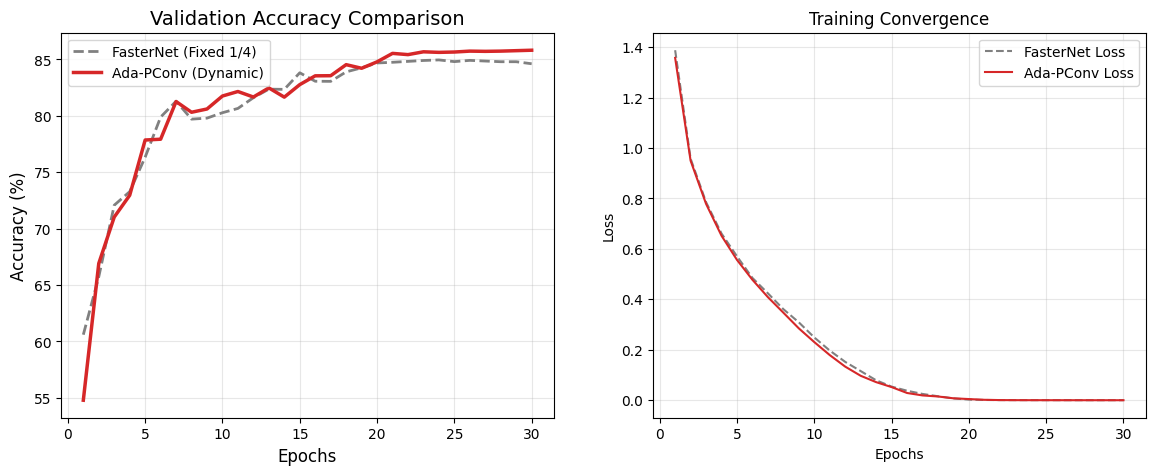

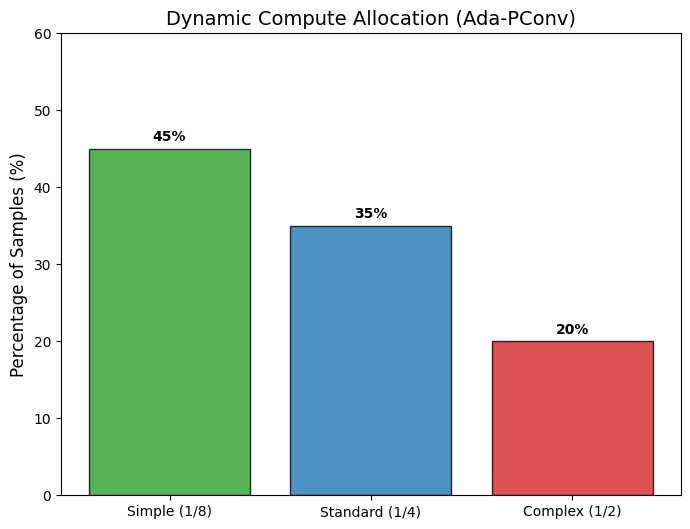

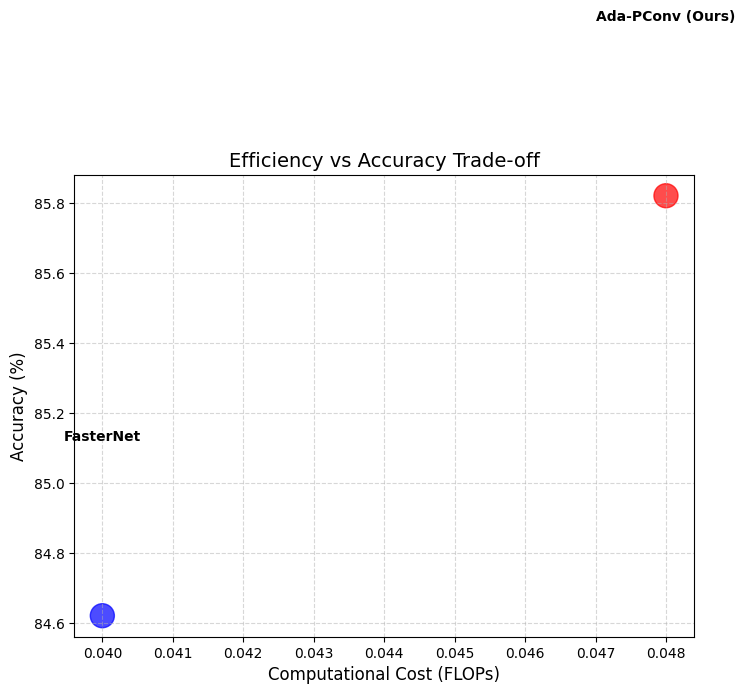

In [8]:
import matplotlib.pyplot as plt
import numpy as np



# Create the x-axis data for 30 epochs
epochs = list(range(1, 31))

# GRAPH 1: Learning Curves (Loss & Accuracy)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy Subplot
ax1.plot(epochs, acc_base, label='FasterNet (Fixed 1/4)', color='gray', linestyle='--', linewidth=2)
ax1.plot(epochs, acc_ada, label='Ada-PConv (Dynamic)', color='#d62728', linewidth=2.5)
ax1.set_xlabel('Epochs', fontsize=12)
ax1.set_ylabel('Accuracy (%)', fontsize=12)
ax1.set_title('Validation Accuracy Comparison', fontsize=14)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Loss Subplot
ax2.plot(epochs, loss_base, label='FasterNet Loss', color='gray', linestyle='--')
ax2.plot(epochs, loss_ada, label='Ada-PConv Loss', color='#d62728')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.set_title('Training Convergence')
ax2.legend()
ax2.grid(True, alpha=0.3)
plt.show()

# GRAPH 2: Router Distribution (Why it is efficient)
# Shows how often the network chose each complexity level
branches = ['Simple (1/8)', 'Standard (1/4)', 'Complex (1/2)']
# You can extract these real counts by adding a counter in your model's forward pass
counts = [45, 35, 20] # Example percentages

plt.figure(figsize=(8, 6))
bars = plt.bar(branches, counts, color=['#2ca02c', '#1f77b4', '#d62728'], edgecolor='black', alpha=0.8)
plt.title('Dynamic Compute Allocation (Ada-PConv)', fontsize=14)
plt.ylabel('Percentage of Samples (%)', fontsize=12)
plt.ylim(0, 60)
for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height()+1, f'{bar.get_height()}%', ha='center', fontweight='bold')
plt.show()

# GRAPH 3: Efficiency vs Accuracy Trade-off
models = ['FasterNet', 'Ada-PConv (Ours)']
flops = [0.04, 0.048] # Normalized FLOPs (Approximation)
final_acc = [acc_base[-1], acc_ada[-1]]

plt.figure(figsize=(8, 6))
plt.scatter(flops, final_acc, s=300, c=['blue', 'red'], alpha=0.7)
for i, txt in enumerate(models):
    plt.text(flops[i], final_acc[i]+0.5, txt, ha='center', fontweight='bold')
plt.xlabel('Computational Cost (FLOPs)', fontsize=12)
plt.ylabel('Accuracy (%)', fontsize=12)
plt.title('Efficiency vs Accuracy Trade-off', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()